Data Description

Demographic:

• Sex: male or female("M" or "F")

• Age: Age of the patient;(Continuous - Although the recorded ages have been truncated to whole numbers, the concept of age is continuous).

Behavioral
• is_smoking: whether or not the patient is a current smoker ("YES" or "NO")

• Cigs Per Day: the number of cigarettes that the person smoked on average in one day.(can be considered continuous as one can have any number of cigarettes, even half a cigarette.)

Medical( history)

• BP Meds: whether or not the patient was on blood pressure medication (Nominal)

• Prevalent Stroke: whether or not the patient had previously had a stroke (Nominal)

• Prevalent Hyp: whether or not the patient was hypertensive (Nominal)

• Diabetes: whether or not the patient had diabetes (Nominal)

Medical(current)

• Tot Chol: total cholesterol level (Continuous)

• Sys BP: systolic blood pressure (Continuous)

• Dia BP: diastolic blood pressure (Continuous)
• BMI: Body Mass Index (Continuous)

• Heart Rate: heart rate (Continuous - In medical research, variables such as heart rate though infact discrete, yet are considered continuous because of large number of possible values.)

• Glucose: glucose level (Continuous)



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statistics as s
from sklearn.impute import KNNImputer
## Will delete if not req
from numpy import math

In [2]:
##used to ignore warning messages
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pip install imbalanced-learn

In [5]:
data = pd.read_csv("/content/drive/MyDrive/Almabetter learning/Cardiovascular Risk Prediction/data_cardiovascular_risk.csv")
print("Dataset size")
print("Rows {} Columns {}".format(data.shape[0], data.shape[1]))

Dataset size
Rows 3390 Columns 17


In [6]:
data.sample(5)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
3309,3309,44,3.0,F,YES,20.0,0.0,0,0,0,240.0,109.0,71.0,23.75,70.0,83.0,0
231,231,45,1.0,M,YES,30.0,0.0,0,0,0,240.0,141.0,89.0,25.01,95.0,76.0,0
1342,1342,40,4.0,M,NO,0.0,0.0,0,1,0,213.0,145.0,100.5,27.34,95.0,117.0,0
3276,3276,67,3.0,F,NO,0.0,0.0,0,1,0,260.0,140.0,88.0,24.67,55.0,65.0,0
444,444,46,2.0,F,NO,0.0,0.0,0,1,0,264.0,150.0,99.0,26.67,80.0,102.0,0


In [7]:
# Id dropped as not req
data.drop(columns=['id'],inplace=True)

In [8]:
data.isna().sum()

age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

Data Analysis

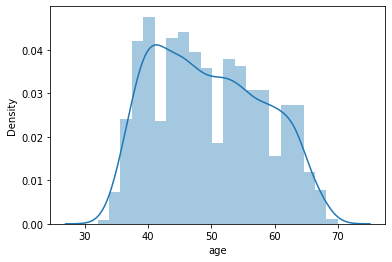

In [9]:
sns.distplot(data['age']);

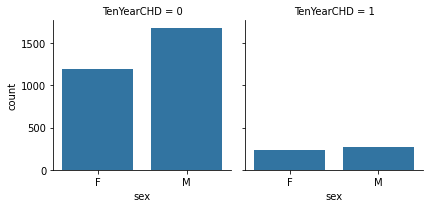

In [10]:
fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'sex').add_legend()
# show the object
plt.show()

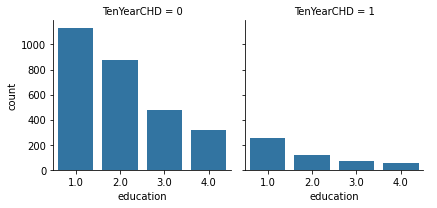

In [11]:

fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'education').add_legend()
# show the object
plt.show()

In [12]:
data['education'].describe()

count    3303.000000
mean        1.970936
std         1.019081
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000
Name: education, dtype: float64

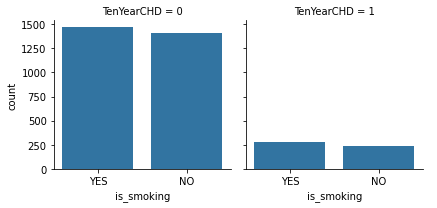

In [13]:
fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'is_smoking').add_legend()
# show the object
plt.show()

In [14]:
data['prevalentStroke'].describe()

count    3390.000000
mean        0.006490
std         0.080309
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: prevalentStroke, dtype: float64

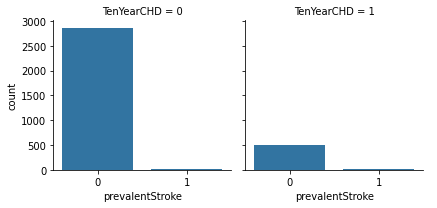

In [15]:
fct=sns.FacetGrid(data=data,col='TenYearCHD')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'prevalentStroke').add_legend()
# show the object
plt.show()

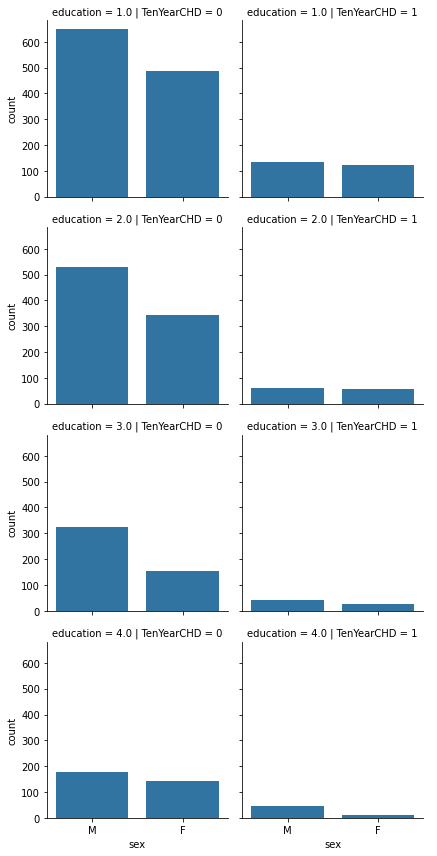

In [16]:
fct=sns.FacetGrid(data=data,col='TenYearCHD',row='education')
# map the above form facetgrid with some attributes
fct.map(sns.countplot,'sex').add_legend()
# show the object
plt.show()

In [17]:
data[['sysBP','diaBP','BMI','heartRate','glucose']].describe()

,sysBP,diaBP,BMI,heartRate,glucose
count,3390.00000,3390.000000,3376.000000,3389.000000,3086.000000
mean,132.60118,82.883038,25.794964,75.977279,82.086520
std,22.29203,12.023581,4.115449,11.971868,24.244753
min,83.50000,48.000000,15.960000,45.000000,40.000000
25%,117.00000,74.500000,23.020000,68.000000,71.000000
50%,128.50000,82.000000,25.380000,75.000000,78.000000
75%,144.00000,90.000000,28.040000,83.000000,87.000000
max,295.00000,142.500000,56.800000,143.000000,394.000000


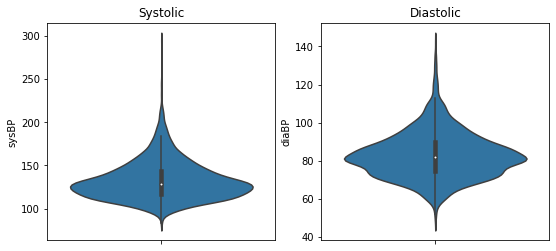

In [18]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
sns.violinplot(data=data,y='sysBP')
plt.title("Systolic")
plt.subplot(1,2,2)
sns.violinplot(data=data,y='diaBP',)
plt.title("Diastolic")
#plt.legends()
plt.show()

In [19]:
data.columns

Index(['age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [20]:
data[data['sysBP']==max(data['sysBP'])]

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
1941,64,1.0,F,NO,0.0,0.0,0,1,0,253.0,295.0,135.0,38.82,92.0,70.0,1


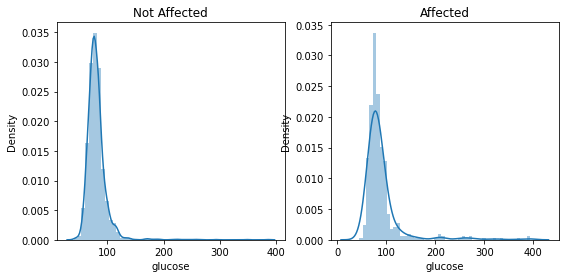

In [21]:
#sns.distplot(data['glucose']);
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
sns.distplot(data[data['TenYearCHD']==0]['glucose']);
plt.title("Not Affected")
plt.subplot(1,2,2)
sns.distplot(data[data['TenYearCHD']==1]['glucose']);
plt.title("Affected")
#plt.legends()
plt.show()

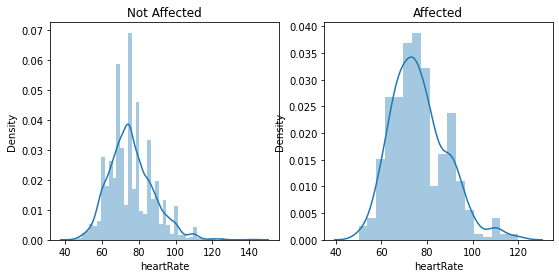

In [22]:
#sns.distplot(data['glucose']);
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
sns.distplot(data[data['TenYearCHD']==0]['heartRate']);
plt.title("Not Affected")
plt.subplot(1,2,2)
sns.distplot(data[data['TenYearCHD']==1]['heartRate']);
plt.title("Affected")
#plt.legends()
plt.show()

Handling Null Values

In [23]:
# Imputed null values with mode
data['BPMeds']=data['BPMeds'].fillna(s.mode(data['BPMeds']))

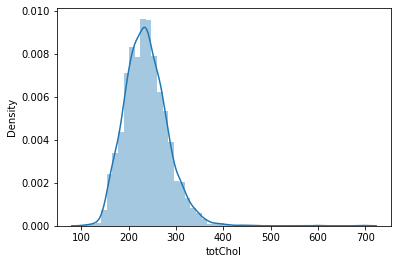

In [24]:
sns.distplot(data['totChol']);

In [25]:
# Less than 400 almost Normal, impute with mean
data['totChol']=data['totChol'].fillna(np.mean(data[data['totChol']<=400]['totChol']))

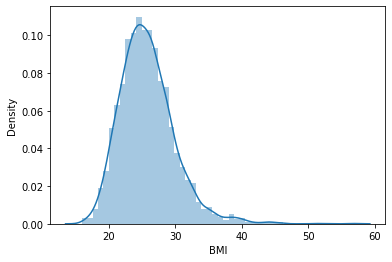

In [26]:
sns.distplot(data['BMI']);

In [27]:
# Less than 36 almost Normal, impute with mean
data['BMI']=data['BMI'].fillna(np.mean(data[data['BMI']<=36]['BMI']))

In [28]:
## CigsPerDay 22 nulls needs imputation as is_smoking is yes all 22 records
data[(data.cigsPerDay.isna()) & (data.is_smoking!='YES')]

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD


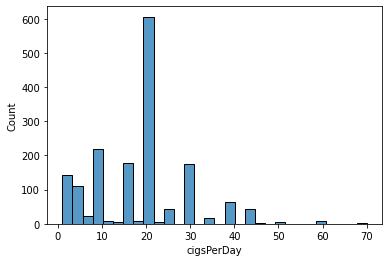

In [29]:
#data['cigsPerDay'].value_counts()

sns.histplot(data[data['cigsPerDay']!=0]['cigsPerDay'],bins=30);
## Bar plot gives an idea about what count of cigsperday is observed in more numbers

In [30]:
data['cigsPerDay']=data['cigsPerDay'].fillna(np.random.randint(5,30))

In [31]:
data['heartRate']=data['heartRate'].fillna(np.mean(data['heartRate']))

In [32]:
data.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,25.500835,90.0,80.0,1
1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.770000,72.0,75.0,0
2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.350000,88.0,94.0,0
3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.260000,68.0,94.0,1
4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.420000,70.0,77.0,0


In [33]:
# Encoding this categorical to prepare data for KNN impute
data['is_smoking']=data['is_smoking'].apply(lambda x:1 if x=='YES' else 0)
data['sex']=data['sex'].apply(lambda x:1 if x=='M' else 0)

In [34]:
#data[data['glucose'].isna()]
# define imputer
imputer = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')

In [35]:
# fit on the dataset
imputer.fit(data)

KNNImputer(n_neighbors=10)

In [36]:
# transform the dataset
data_trans = pd.DataFrame(imputer.transform(data),columns=data.columns)

In [37]:
data_trans.isna().sum().sum()

0

In [38]:
data['TenYearCHD'].value_counts()

0    2879
1     511
Name: TenYearCHD, dtype: int64

In [39]:
#### Tasks to be done Apply Logistic and other model to check

In [40]:
data=data_trans.copy()

In [41]:
X=data.iloc[:,0:-1]
y=data.iloc[:,-1]

In [42]:
from sklearn.model_selection import train_test_split

In [43]:
##import imblearn
##sample=SMOTE()

In [44]:
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import cross_validate,RepeatedStratifiedKFold,cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix

In [45]:
X_train,X_test,y_train,y_test=train_test_split(X,y)

In [46]:
weights={0:0.15,1:0.85}

In [139]:
#logistic = LogisticRegression(C=10.0,class_weight='balanced',penalty='l2',random_state=30, solver='lbfgs',)
#logistic = LogisticRegression(C=10.0,class_weight=weights,penalty='l2',random_state=30, solver='lbfgs',)
logistic = LogisticRegression(C=10.0,penalty='l2',random_state=30, solver='lbfgs',)

In [48]:
# C=1.0, class_weight=None, dual=False, fit_intercept=True,
#                     intercept_scaling=1, l1_ratio=None, max_iter=100,
#                     multi_class='auto', n_jobs=None, penalty='l2',
#                     random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
#                     warm_start=False

In [140]:
logistic

LogisticRegression(C=10.0, random_state=30)

In [50]:
#The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class 
#frequencies in the input data as n_samples / (n_classes * np.bincount(y)).

#Note that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified.

In [51]:
scoring = ['roc_auc']
scores = cross_validate(logistic,X_train, y_train, scoring = scoring, cv = 5, return_train_score=True,return_estimator=True,verbose = 10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] START .....................................................................
[CV] END ................. roc_auc: (train=0.686, test=0.691) total time=   0.1s
[CV] START .....................................................................
[CV] END ................. roc_auc: (train=0.677, test=0.671) total time=   0.1s
[CV] START .....................................................................
[CV] END ................. roc_auc: (train=0.698, test=0.689) total time=   0.1s
[CV] START .....................................................................
[CV] END ................. roc_auc: (train=0.687, test=0.658) total time=   0.1s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s


[CV] END ................. roc_auc: (train=0.686, test=0.683) total time=   0.1s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished


In [52]:
scores

{'estimator': [LogisticRegression(C=10.0, class_weight={0: 0.15, 1: 0.85}, random_state=30),
  LogisticRegression(C=10.0, class_weight={0: 0.15, 1: 0.85}, random_state=30),
  LogisticRegression(C=10.0, class_weight={0: 0.15, 1: 0.85}, random_state=30),
  LogisticRegression(C=10.0, class_weight={0: 0.15, 1: 0.85}, random_state=30),
  LogisticRegression(C=10.0, class_weight={0: 0.15, 1: 0.85}, random_state=30)],
 'fit_time': array([0.10539341, 0.10163617, 0.06954956, 0.06907368, 0.08971334]),
 'score_time': array([0.00546455, 0.00577164, 0.00534391, 0.00532246, 0.00537252]),
 'test_roc_auc': array([0.69056157, 0.67059682, 0.68917519, 0.65768153, 0.68267898]),
 'train_roc_auc': array([0.68566741, 0.67749099, 0.69775574, 0.68700059, 0.68585146])}

In [53]:
#scores['train_accuracy']

In [54]:
#scores['test_accuracy']

In [55]:
#scores['estimator']

In [141]:
logistic.fit(X_train,y_train)

LogisticRegression(C=10.0, random_state=30)

Evaluate model performance

In [142]:
# Get the predicted probabilities
train_preds = logistic.predict_proba(X_train)
test_preds = logistic.predict_proba(X_test)

In [143]:
type(train_preds
)

numpy.ndarray

In [144]:
#train_preds[:,:]

In [145]:
#np.array(pd.DataFrame(train_preds,columns=['No','Yes']).head()['Yes'])

In [146]:
#train_preds=train_preds[:,:1]
#test_preds=test_preds[:,:1]

In [147]:
test_preds_df=pd.DataFrame(test_preds,columns=['No','Yes'])
test_preds=np.array(test_preds_df['Yes'])

In [148]:
# test_preds.shape
# y_test.shape

(848,)

In [73]:
from sklearn.metrics import roc_curve

In [149]:
fpr, tpr, thresholds = roc_curve(y_test, test_preds)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.146005, G-Mean=0.639


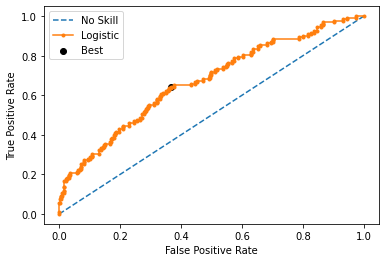

In [150]:

# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

In [152]:
# test_preds_new=np.array(test_preds_df['Yes'].apply(lambda x:1 if x>=0.501637 else 0))
test_preds_new=np.array(test_preds_df['Yes'].apply(lambda x:1 if x>=0.146005 else 0))

In [153]:
#thresholds = np.arange(0.5016330, 0.5016350, 0.0000001)

In [154]:
# for i in thresholds:
#   test_preds_new=np.array(test_preds_df['Yes'].apply(lambda x:1 if x>=i else 0))
#   print("For threshold {:.7f}".format(i))
#   print(confusion_matrix(y_test, test_preds_new))
#   print(precision_score(y_test, test_preds_new))
#   print(recall_score(y_test, test_preds_new))

In [155]:
# Get the predicted classes
#train_class_preds = logistic.predict(X_train)
#test_class_preds = logistic.predict(X_test)

[[454 262]
 [ 48  84]]


[Text(0, 0.5, 'Not at Risk'), Text(0, 1.5, 'Heart Risk')]

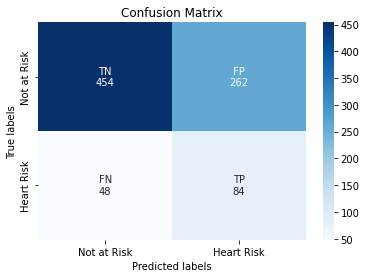

In [156]:
# Get the confusion matrix for test

labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, test_preds_new)
print(cm)

cat = ['TN','FP','FN','TP']
#cat = np.asarray(labels2).reshape(2,2)
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot()
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [157]:
## Calc Precision and recall
from sklearn.metrics import roc_auc_score,recall_score,precision_score

roc_auc = roc_auc_score(y_test, test_preds_new)


In [158]:
roc_auc

0.6352209243270697

In [159]:
precision = precision_score(y_test, test_preds_new)#, average='binary')
recall = recall_score(y_test, test_preds_new)#, average='binary')

In [160]:
print(precision)
print("\n")
print(recall)

0.24277456647398843


0.6363636363636364


In [64]:
from sklearn.model_selection import GridSearchCV

In [65]:
grid={
'C':[100, 10, 1.0, 0.1, 0.01],
'class_weight':[{0:0.15,1:0.85},{0:0.12,1:0.88},{0:0.1,1:0.9},{0:0.3,1:0.7}],
'penalty':['none', 'l1', 'l2', 'elasticnet'],
'solver':['newton-cg', 'lbfgs', 'sag', 'saga']
}
logistic = LogisticRegression()

In [66]:
grid_search = GridSearchCV(estimator=logistic, param_grid=grid, n_jobs=-1, scoring='f1',error_score=0)
grid_result = grid_search.fit(X, y)

In [67]:
grid_result.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_class_weight', 'param_penalty', 'param_solver', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])

In [68]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

In [69]:
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.373598 (0.028627) with: {'C': 100, 'class_weight': {0: 0.15, 1: 0.85}, 'penalty': 'none', 'solver': 'newton-cg'}
0.348950 (0.025284) with: {'C': 100, 'class_weight': {0: 0.15, 1: 0.85}, 'penalty': 'none', 'solver': 'lbfgs'}
0.327677 (0.010723) with: {'C': 100, 'class_weight': {0: 0.15, 1: 0.85}, 'penalty': 'none', 'solver': 'sag'}
0.328363 (0.011674) with: {'C': 100, 'class_weight': {0: 0.15, 1: 0.85}, 'penalty': 'none', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 100, 'class_weight': {0: 0.15, 1: 0.85}, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'class_weight': {0: 0.15, 1: 0.85}, 'penalty': 'l1', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 100, 'class_weight': {0: 0.15, 1: 0.85}, 'penalty': 'l1', 'solver': 'sag'}
0.329247 (0.010825) with: {'C': 100, 'class_weight': {0: 0.15, 1: 0.85}, 'penalty': 'l1', 'solver': 'saga'}
0.373598 (0.028627) with: {'C': 100, 'class_weight': {0: 0.15, 1: 0.85}, 'penalty': 'l2', 'solver': 'newton-cg'}
0.346

In [70]:
grid_result.best_params_

{'C': 0.1,
 'class_weight': {0: 0.15, 1: 0.85},
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [71]:
tuned_logistic=LogisticRegression(C=0.11, class_weight= {0: 0.15, 1: 0.85}, penalty='l2',solver='newton-cg')
tuned_logistic.fit(X_train,y_train)

LogisticRegression(C=0.11, class_weight={0: 0.15, 1: 0.85}, solver='newton-cg')

In [72]:
# Get the predicted classes
train_class_preds = tuned_logistic.predict(X_train)
test_class_preds = tuned_logistic.predict(X_test)

[[475 246]
 [ 44  83]]


[Text(0, 0.5, 'Not at Risk'), Text(0, 1.5, 'Heart Risk')]

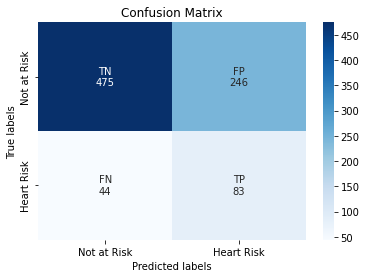

In [73]:
# Get the confusion matrix for test

labels = ['Not at Risk','Heart Risk' ]
cm = confusion_matrix(y_test, test_class_preds)
print(cm)

cat = ['TN','FP','FN','TP']
#cat = np.asarray(labels2).reshape(2,2)
counts = [count for count in cm.flatten()]
labelsIn = [f"{v1}\n{v2}" for v1, v2 in  zip(cat,counts)]

labelsIn = np.asarray(labelsIn).reshape(2,2)

ax= plt.subplot()
sns.heatmap(cm, annot=labelsIn, ax = ax,fmt='', cmap='Blues');

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [74]:
## Calc Precision and recall
from sklearn.metrics import roc_auc_score,recall_score,precision_score

roc_auc = roc_auc_score(y_test, test_class_preds)


In [75]:
roc_auc

0.6561752596459423

In [76]:
precision = precision_score(y_test, test_class_preds, average='binary')
recall = recall_score(y_test, test_class_preds, average='binary')

In [77]:
print(precision)
print("\n")
print(recall)

0.25227963525835867


0.6535433070866141
